In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from Bio import SeqIO
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from config import *
import util.misc as utils
from models.nt_classifier import build as build_model
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


### Only hardneg not containing regions of interaction from scratch

In [53]:
# MAX_SIZE = 5970
#N_MAX_SAMPLES = 10000000
# check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/my_check_predictions_ricseq'
# embedding_dir = os.path.join(check_data_path, 'embeddings')

In [3]:
MAX_SIZE = 5969
N_MAX_SAMPLES = 100_000
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/my_check_predictions_ricseq5969'
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [4]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')
            print(df.shape[0])

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [5]:
import random

def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

def find_possible_interval(rna1_coords, len_rna1):
    max_interval_length = len_rna1  # min(5970, len_rna1)

    # Add boundaries to the list of coordinates
    extended_coords = [(0, -1)] + sorted(rna1_coords) + [(len_rna1, len_rna1 + 1)]

    # Initialize variables to keep track of the largest interval
    largest_interval_start = 0
    largest_interval_end = 0
    largest_interval_length = 0

    # Iterate through the sorted coordinates to find the gaps
    for i in range(len(extended_coords) - 1):
        current_end = extended_coords[i][1]
        next_start = extended_coords[i + 1][0]

        # Calculate the gap between the current end and the next start
        gap_start = current_end + 1
        gap_end = next_start - 1
        gap_length = gap_end - gap_start + 1

        # Check if this gap is the largest found so far and within the max limit
        if gap_length > largest_interval_length and gap_length <= max_interval_length:
            largest_interval_start = gap_start
            largest_interval_end = gap_end
            largest_interval_length = gap_length

    # The interval should be [largest_interval_start, largest_interval_end]
    # But to ensure it is within the allowed maximum length
    if largest_interval_length > max_interval_length:
        largest_interval_end = largest_interval_start + max_interval_length - 1

    largest_interval = (largest_interval_start, largest_interval_end)
    return largest_interval

def find_random_interval(start, end, max_length):
    # Calculate the length of the input interval
    length_of_input_interval = end - start
    # Calculate the maximum possible length for the random interval
    max_interval_length = min(max_length, length_of_input_interval)
    
    # Generate a random starting point
    random_start = random.randint(start, end - max_interval_length)
    # Calculate the ending point of the interval
    random_end = random_start + max_interval_length
    
    return (random_start, random_end)

def find_hardneg_window(rna_coords, len_rna):
    interval = find_possible_interval(rna_coords, len_rna)
    return find_random_interval(interval[0], interval[1], MAX_SIZE)

In [6]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
ricseq_exp = all_interactions[all_interactions.experiment.isin(ricseq_experiments)].reset_index(drop = True)

In [7]:
ricseq_exp['couple'] = ricseq_exp['tr1'] + '_' + ricseq_exp['tr2']

ricseq_exp['couple_swap'] = ricseq_exp['tr2'] + '_' + ricseq_exp['tr1']
to_drop = set(ricseq_exp[ricseq_exp['couple'].isin(set(ricseq_exp['couple_swap'] ))].couple)
ricseq_exp = ricseq_exp[~ricseq_exp.couple.isin(to_drop)]
ricseq_exp = ricseq_exp.drop('couple_swap', axis = 1)

# 2 or more reads
ricseq_exp = ricseq_exp[ricseq_exp.n_reads.astype(int)>1]

In [8]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))

In [9]:
list_of_pos_couples = set(ricseq_exp.couple)

In [ ]:
diz = {}
idx=0

for couple in tqdm(list_of_pos_couples):
    
    all_interactions = ricseq_exp[ricseq_exp.couple == couple]

    rna1_coords = []
    rna2_coords = []

    for _, row in all_interactions.iterrows():
        rna1_coords.append((row.x1, row.x2))
        rna2_coords.append((row.y1, row.y2))

    len_rna1 = df_genes[df_genes.ensembl_transcript_id == row.tr1].length.iloc[0]
    len_rna2 = df_genes[df_genes.ensembl_transcript_id == row.tr2].length.iloc[0]

    
    if (len_rna1>8_000)&(len_rna2>8_000):
        n_iters = 3
    else:
        n_iters = 1
        
    for i in range(n_iters):
        embedding1_interval = find_hardneg_window(rna1_coords, len_rna1)
        emb_length1 = embedding1_interval[1] - embedding1_interval[0]

        embedding2_interval = find_hardneg_window(rna2_coords, len_rna2)
        emb_length2 = embedding2_interval[1] - embedding2_interval[0]

        if (emb_length1>550) & (emb_length2>550): # I calculate only if the embedding has at least length of 550

            x1, x2 = find_random_interval(0, emb_length1, 500)
            y1, y2 = find_random_interval(0, emb_length2, 500)

            diz[idx] = {'couple': couple, 
                        'transcript1':row.tr1,
                        'transcript2':row.tr2,
                        'start_emb1':embedding1_interval[0],
                        'end_emb1':embedding1_interval[1],
                        'x1':x1,
                        'x2':x2,
                        'start_emb2':embedding2_interval[0],
                        'end_emb2':embedding2_interval[1],
                        'y1':y1,
                        'y2':y2,
                        'original_len1':len_rna1,
                        'original_len2':len_rna2,
                       }

            idx+=1

In [62]:
hn = pd.DataFrame.from_dict(diz, orient = 'index')

In [65]:
diz = {}
for idx, row in tqdm(hn.iterrows(), total = hn.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = ricseq_exp[(ricseq_exp['tr1'] == tr1)&(ricseq_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/9592 [00:00<?, ?it/s]

In [66]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')
final_hn = pd.concat([hn, distances], axis = 1)

In [67]:
wrong=final_hn[((final_hn.distance_x>0) & (final_hn.distance_y>0)) == False]
# sono solo 7, shalla
wrong.shape[0]

7

In [68]:
final_hn = final_hn[((final_hn.distance_x>0) & (final_hn.distance_y>0)) == True].reset_index(drop = True)

In [76]:
final_hn = final_hn.sample(min(N_MAX_SAMPLES, final_hn.shape[0]))

In [77]:
final_hn.shape[0]

1000

In [78]:
final_hn[(final_hn.distance_x>200)&(final_hn.distance_y>200)].shape[0]

79

In [79]:
#sono tutte 500 X 500
(final_hn.x2-final_hn.x1).min() == (final_hn.x2-final_hn.x1).max() == (final_hn.y2-final_hn.y1).min() == 500

True

In [81]:
assert (final_hn.end_emb1-final_hn.start_emb1).max() == (final_hn.end_emb2-final_hn.start_emb2).max() == MAX_SIZE

In [82]:
(final_hn.end_emb1-final_hn.start_emb1).min(), (final_hn.end_emb2-final_hn.start_emb2).min() 

(563, 560)

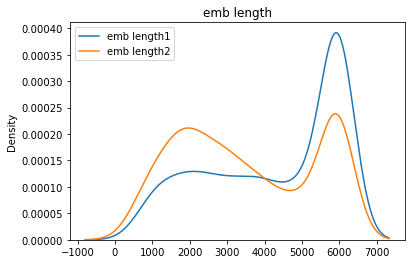

In [83]:
plt.title('emb length')
sns.kdeplot(data=list(final_hn.end_emb1-final_hn.start_emb1), label = 'emb length1')
sns.kdeplot(data=list(final_hn.end_emb2-final_hn.start_emb2), label = 'emb length2')
plt.legend()

In [84]:
final_hn['id_pair'] = final_hn.index

In [85]:
final_hn['embedding1name'] = final_hn.transcript1 + '_' + final_hn.start_emb1.astype(str) + '_' + final_hn.end_emb1.astype(str)
final_hn['embedding2name'] = final_hn.transcript2 + '_' + final_hn.start_emb2.astype(str) + '_' + final_hn.end_emb2.astype(str)

In [86]:
final_hn = final_hn.rename(columns={
            'x1': 'start_window1',
            'x2': 'end_window1',
            'y1': 'start_window2',
            'y2': 'end_window2',
        })

In [87]:
final_hn.to_csv(os.path.join(check_data_path, 'df_hn.csv'), index = False)

In [88]:
pairs = final_hn[['embedding1name', 'embedding2name','id_pair', 'start_window1', 'end_window1', 'start_window2', 'end_window2']]
pairs.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

#### creo df_query

In [89]:
idx = 0
diz_q = {}
for _, row in final_hn.iterrows():
    
    cdna1 = df_genes[df_genes.ensembl_transcript_id == row.transcript1].cdna.iloc[0]
    cdna1 = cdna1[row.start_emb1: row.end_emb1]
    
    cdna2 = df_genes[df_genes.ensembl_transcript_id == row.transcript2].cdna.iloc[0]
    cdna2 = cdna2[row.start_emb2: row.end_emb2]
    
    
    assert len(cdna1) == row.end_emb1 - row.start_emb1
    assert len(cdna2) == row.end_emb2 - row.start_emb2
    
    
    diz_q[idx] = {
        'id_query': row.embedding1name, 
        'cdna': cdna1
    }
    idx +=1
    
    diz_q[idx] = {
        'id_query': row.embedding2name, 
        'cdna': cdna2
    }
    idx +=1

In [90]:
df_query = pd.DataFrame.from_dict(diz_q, orient = 'index')
df_query = df_query.drop_duplicates().reset_index(drop = True)

In [91]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 0.47
estimated # days: 0.02
estimated terabytes (pessimistic): 0.02
estimated terabytes (realistic): 0.01


In [92]:
df_query.to_csv(os.path.join(check_data_path, f'embedding_query.csv'), index = False)

In [93]:
assert set(df_query.id_query) == set(pairs.embedding1name).union(pairs.embedding2name)

### Read the results

In [10]:
final_hn = pd.read_csv(os.path.join(check_data_path, 'df_hn.csv'))
predictions = pd.read_csv(os.path.join(check_data_path, 'predictions.csv'))

final_hn = final_hn.merge(predictions, left_on = 'id_pair', right_on = 'id_sample')


vc = (final_hn.probability<0.5).value_counts()
tnr = (vc.loc[True])/ final_hn.shape[0]
print(tnr)

0.795


In [18]:
final_hn = final_hn[(final_hn['end_emb2'] - final_hn['start_emb2'] == 5969) & (final_hn['end_emb1'] - final_hn['start_emb1'] == 5969)]

vc = (final_hn.probability<0.5).value_counts()
tnr = (vc.loc[True])/ final_hn.shape[0]
print(tnr)

0.9745762711864406


##### Compare results with df_nt results

In [11]:
from util.evaluation import *

def load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, specie_paris, paris_hq, paris_hq_threshold):
    
    if type(checkpoint_dir) == str:
        checkpoint_dir = [checkpoint_dir]
    else:
        assert type(checkpoint_dir) == list
        assert type(checkpoint_dir[0]) == str

    if dataset == 'paris':
        
        test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        assert test500.shape[0] == df_nt[['couples', 'interacting']].merge(test500, on = 'couples').shape[0]
        test500 = df_nt[['couples', 'interacting']].merge(test500, on = 'couples').reset_index(drop = True)
        
        for i in range(len(checkpoint_dir)):
            r = load_paris_results(checkpoint_dir[i], test500, df_nt, 'test', specie_paris)
            if paris_hq:
                r = filter_hq_data_by_interaction_length(r, test500, paris_hq_threshold)
                
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
    else:
        test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
        test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
        test500['distance_from_site_embedding'] = ( (test500['distance_embedding_x'] ** 2) + (test500['distance_embedding_y']** 2) )**(0.5) #pitagora
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
        assert df_nt[['couples', 'interacting']].drop_duplicates().shape[0] == df_nt.shape[0]
        test500 = df_nt[['couples', 'interacting']].merge(test500, on = 'couples') #questo interacting verra poi
        
        for i in range(len(checkpoint_dir)):
            r = load_ricseq_splash_mario_results(checkpoint_dir[i], test500, df_nt, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)
            if i == 0:
                res = r.copy()
            else:
                r = r.rename({'probability':f'nt{i}'}, axis = 1)
                res = pd.concat([res, r[f'nt{i}']], axis = 1)
    
    assert (res['ground_truth'] == res['interacting'].astype(int)).all()
    
    
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        res = res.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left').fillna(0)

    
    #mi serve solo per il merge, poi le elimino queste colonne
    if dataset == 'splash':
        df_nt['simple_repeats'] = np.nan
        df_nt['sine_alu'] = np.nan 
        df_nt['low_complex'] = np.nan 
        df_nt['n_reads'] = np.nan 
    
    #now we merge with ENHN500
    testenhn500 = pd.read_csv(os.path.join(metadata_dir, f'{how}ENHN500.csv'))
    testenhn500['distance_from_site'] = ( (testenhn500['distance_x'] ** 2) + (testenhn500['distance_y']** 2) )**(0.5) #pitagora
    testenhn500['distance_from_site_embedding'] = ( (testenhn500['distance_embedding_x'] ** 2) + (testenhn500['distance_embedding_y']** 2) )**(0.5) #pitagora
    testenhn500 = df_nt[['couples', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(testenhn500, on = 'couples')
    
    for i in range(len(checkpoint_dir)):
        r = pd.read_csv(os.path.join(checkpoint_dir[i], f'{how}ENHN_results500.csv')).drop('policy', axis = 1)
        # qui e necessario perche 'ground_truth' è preso da df_nt, che originariamente mette positivi gli hardneg. 
        # invece in ENHN500 quello che in df_nt era un positivo diventa un negativo (hardneg, easyneg). comunque queste colonne verranno sovrascritte dopo
        r['ground_truth'] = 0
        r['interacting'] = False
        if i == 0:
            enhn = r.copy()
        else:
            r = r.rename({'probability':f'nt{i}'}, axis = 1)
            enhn = pd.concat([enhn, r[f'nt{i}']], axis = 1)
    
    if dataset == 'ricseq':
        #aggiungi n_reads a testenhn500, quindi a enhn (visto che poi lo mergio con testenhn500)
        to_merge = res[['id_sample', 'n_reads']].rename({'id_sample':'couples'}, axis = 1).drop_duplicates().reset_index(drop=True)
        assert len(set(to_merge.couples)) == to_merge.shape[0]
        testenhn500 = testenhn500.merge(to_merge)
                
           
    #tengo solo le couples di res, perche escludo quelle che erano tipo nel training di paris, oppure solo paris human, oppure quelle < n_reads_ricseq, ecc... 
    enhn = enhn[enhn.couples.isin(res.couples)].reset_index(drop = True)
    
    #policy tengo quello di testenhn500, che sono hn, en
    enhn = enhn.merge(testenhn500.drop(['g1', 'g2'], axis = 1).rename({'couples':'id_sample'}, axis = 1), on = 'id_sample').reset_index(drop = True)

    enhnintarna = load_intarnaENHN500(how)
    enhn = enhn.merge(enhnintarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample', how = 'left').fillna(0)
    enhn['original_area'] = enhn.original_length1 * enhn.original_length2    

    how = how + 'ENHN'
    for tool_name in tools:
        tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
        tool['value'] = tool['value'].astype(float)
        assert (tool.minimum == True).all()
        enhn = enhn.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample', how = 'left')

    # tolgo 'E_norm_conf', 'ensemble_score'
    res = res.filter(list(enhn.columns), axis = 1)
    
    res = pd.concat([res, enhn], axis = 0).reset_index(drop=True)
    
    res = res.drop(['Unnamed: 0', 'simple_repeats', 'sine_alu', 'low_complex'], axis = 1)
    res['dataset'] = dataset
    
    
    # l unica cosa affidabile è la colonna policy, che viene da test500, testenhn500
    res.loc[res.policy.isin(['easyneg', 'hardneg', 'smartneg']), 'interacting'] = False
    res.loc[res.policy.isin(['easyneg', 'hardneg', 'smartneg']), 'ground_truth'] = 0
    res.loc[res.policy.isin(['easypos']), 'interacting'] = True
    res.loc[res.policy.isin(['easypos']), 'ground_truth'] = 1
    
    assert res[res.ground_truth.isna()].shape[0] == res[res.interacting.isna()].shape[0] == 0
    assert (res['ground_truth'] == res['interacting'].astype(int)).all()
    
    return res


def load_test_set_df(external_dataset_dir, checkpoint_dir, tools, dataset, args_datasets):
    
    assert dataset in ['psoralen', 'paris', 'splash', 'mario', 'ricseq', 'paris_mouse']

    if (dataset == 'psoralen'):
        
        dataset, how = 'paris',  'test'
        paris = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
        
        dataset, how = 'splash', 'splash'
        splash = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   args_datasets[how]['SPECIE_PARIS'],
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
        assert set(paris.columns) == set(splash.columns)
        res = pd.concat([paris, splash], axis = 0).reset_index(drop=True)
    
    else: 
        if dataset == 'paris_mouse':
            SPECIE_PARIS = 'mouse'
            dataset = 'paris'
        else:
            SPECIE_PARIS = 'human'
            
        how = dataset if dataset not in ['paris', 'paris_mouse'] else 'test'
        res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                   args_datasets[how]['only_test'], 
                                   args_datasets[how]['exclude_train_genes'], 
                                   args_datasets[how]['exclude_paris_genes'], 
                                   args_datasets[how]['exclude_paris_couples'],
                                   args_datasets[how]['filter_hq_ricseq'], 
                                   args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                   SPECIE_PARIS,
                                   args_datasets[how]['PARIS_HQ'],
                                   args_datasets[how]['PARIS_HQ_THRESHOLD'],)
                  
    return res
    
def obtain_epsn_ephnen_from_res(res):
    easypos_smartneg = res[(res.policy.isin(['easypos', 'smartneg']))].reset_index(drop = True)
    ephnen = res[
        ((res.distance_from_site_embedding > 0)&(res.policy.isin(['hardneg', 'easyneg']))) |
        (res.policy == 'easypos')
    ].reset_index(drop = True)
    enhn500 = res[(res.distance_from_site_embedding == 0)&(res.policy.isin(['easypos', 'hardneg', 'easyneg']))].reset_index(drop = True)
    return easypos_smartneg, ephnen, enhn500

datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAplex', 'rnacofold', 'assa', 'risearch2', 'RNAhybrid', 'RNAup'] #['priblast', 'risearch2'] #['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
PARIS_HQ = False
PARIS_HQ_THRESHOLD = 35
MIN_N_READS_RICSEQ = 2
RICSEQ_HQ = False

RICSEQ_TEST = False
SPLASH_TEST = True

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for paris
                  'SPECIE_PARIS' : 'human',
                  'PARIS_HQ':PARIS_HQ,
                  'PARIS_HQ_THRESHOLD':PARIS_HQ_THRESHOLD,
                 }, 
                 'ricseq': 
                 {'only_test' : RICSEQ_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : RICSEQ_HQ,
                  'MIN_N_READS_RICSEQ' : MIN_N_READS_RICSEQ,
                  'SPECIE_PARIS' : np.nan, #uneuseful for ricseq
                  'PARIS_HQ':np.nan, #uneuseful for ricseq
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for ricseq
                 },
                 'splash': 
                 {'only_test' : SPLASH_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for splash
                  'SPECIE_PARIS' : np.nan, #uneuseful for splash
                  'PARIS_HQ':np.nan, #uneuseful for splash
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for splash
                 },
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan,  #uneuseful for mario
                  'SPECIE_PARIS' : np.nan, #uneuseful for mario
                  'PARIS_HQ':np.nan, #uneuseful for mario
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for mario
                 },
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0064',
            ]

checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', nt_models[0]) 

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]

external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'ricseq', args_datasets)

len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['start_emb1'] = len_emb1[1].astype(int)
res['start_emb2'] = len_emb2[1].astype(int)
res['end_emb1'] = len_emb1[2].astype(int)
res['end_emb2'] = len_emb2[2].astype(int)
res['len_emb1'] = res['end_emb1'] - res['start_emb1']
res['len_emb2'] = res['end_emb2'] - res['start_emb2']

res['emebedding_area'] = res['len_emb1'] * res['len_emb2']

easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 
ephnen = ephnen[ephnen.ground_truth == 0]
enhn500 = enhn500[enhn500.ground_truth == 0]

# excluded couples:  234


In [12]:
ephnen = ephnen.merge(df_genes[['gene_id', 'ensembl_transcript_id']], left_on = 'gene1_original', right_on = 'gene_id').rename({'ensembl_transcript_id':'tr1'}, axis = 1).drop('gene_id', axis=1)
ephnen = ephnen.merge(df_genes[['gene_id', 'ensembl_transcript_id']], left_on = 'gene2_original', right_on = 'gene_id').rename({'ensembl_transcript_id':'tr2'}, axis = 1).drop('gene_id', axis=1)
ephnen['couple_tr'] = ephnen['tr1'] + '_' + ephnen['tr2']

ephnen = ephnen[ephnen.policy == 'hardneg']
ephnen = ephnen[(ephnen.distance_embedding_x > 0)&(ephnen.distance_embedding_y > 0)]

In [77]:
subset_hn = final_hn[final_hn.couple.isin(ephnen['couple_tr'])].reset_index(drop = True) #quelli che non metchano mi sa hanno le coppie invertite
subset_hn_big = subset_hn[(subset_hn['original_len1'] > 8_000)&(subset_hn['original_len2'] > 8_000)].reset_index(drop = True)

In [78]:
vc = (subset_hn.probability<0.5).value_counts()
tnr = (vc.loc[True])/ subset_hn.shape[0]
print(tnr)

0.6813953488372093


In [79]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [80]:
diz_dist = {}

for idx, row in subset_hn.iterrows():
    tr_name = row.couple
    interval1 = [row.start_emb1, row.end_emb1]
    interval2 = [row.start_emb2, row.end_emb2]
    ephnen_subset = ephnen[ephnen.couple_tr == tr_name]
    
    distance_list = []
    ids = []
    for _, row_sub in ephnen_subset.iterrows():
        
        interval1_sub = [row_sub.start_emb1, row_sub.end_emb1]
        interval2_sub = [row_sub.start_emb2, row_sub.end_emb2]
        
        distance1 = abs(interval1_sub[0] - interval1[0]) + abs(interval1_sub[1] - interval1[1]) 
        distance2 = abs(interval2_sub[0] - interval2[0]) + abs(interval2_sub[1] - interval2[1]) 
        
        distance = distance1 + distance2
        
        distance_list.append(distance)
        
        ids.append(row_sub.id_sample)
        
    
    diz_dist[idx] = {
        'min_distance':min(distance_list),
        'id_min_distance':ids[np.argmin(min_distance_list)]
                    }

In [81]:
subset_hn = pd.concat([subset_hn, pd.DataFrame.from_dict(diz_dist, orient = 'index')], axis = 1)

In [82]:
subset_hn.min_distance.min(), subset_hn.min_distance.max()

(446, 22499)

In [83]:
subset_hn = subset_hn.merge(
    ephnen[['probability', 'id_sample']].rename({'probability':'original_probability', 'id_sample':'id_min_distance'},axis = 1),
    on = 'id_min_distance')

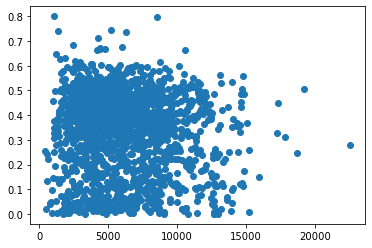

In [84]:
plt.scatter(subset_hn.min_distance, abs(subset_hn.probability - subset_hn.original_probability))

In [103]:
s = subset_hn[subset_hn.min_distance<1500]

vc = (s.probability<0.5).value_counts()
tnr = (vc.loc[True])/ s.shape[0]
print(tnr)

0.7567567567567568


In [104]:
s.shape[0]

37

In [30]:
tr_name = subset_hn_big.iloc[0].couple

In [21]:
tr_name

'ENST00000613296_ENST00000317147'

In [22]:
row_final_hn = final_hn[final_hn.couple==tr_name].iloc[0]

In [23]:
row_final_hn.probability

0.5027517676353455

In [24]:
row_final_hn.distance_x, row_final_hn.transcript1,  row_final_hn.start_emb1, row_final_hn.end_emb1, row_final_hn.start_window1, row_final_hn.end_window1 

(1141, 'ENST00000613296', 2703, 8673, 3481, 3981)

In [25]:
row_final_hn.distance_y, row_final_hn.transcript2,  row_final_hn.start_emb2, row_final_hn.end_emb2, row_final_hn.start_window2, row_final_hn.end_window2 

(906, 'ENST00000317147', 1784, 7754, 5293, 5793)

In [26]:
row_ephnen = ephnen[ephnen.couple_tr == tr_name].iloc[0]

In [27]:
row_ephnen.probability

0.1267641484737396

In [28]:
row_ephnen.distance_embedding_x, row_ephnen.tr1,  row_ephnen.start_emb1, row_ephnen.end_emb1, row_ephnen.x1, row_ephnen.x2 

(1933, 'ENST00000613296', 1912, 7881, 602, 1102)

In [29]:
row_ephnen.distance_embedding_y, row_ephnen.tr2,  row_ephnen.start_emb2, row_ephnen.end_emb2, row_ephnen.y1, row_ephnen.y2 

(13, 'ENST00000317147', 891, 6860, 15, 515)

#### Ne creo uno nuovo che fa le stesse predizioni di res (ma a lunghezza massima 5969)

In [36]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/my_check_predictions_ricseq5969'
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [37]:
res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'ricseq', args_datasets)

len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['start_emb1'] = len_emb1[1].astype(int)
res['start_emb2'] = len_emb2[1].astype(int)
res['end_emb1'] = len_emb1[2].astype(int)
res['end_emb2'] = len_emb2[2].astype(int)
res['len_emb1'] = res['end_emb1'] - res['start_emb1']
res['len_emb2'] = res['end_emb2'] - res['start_emb2']

easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 

# excluded couples:  234


In [38]:
ephnen = ephnen[ 
    ~((ephnen.len_emb1 == ephnen.x2) | (ephnen.len_emb2 == ephnen.y2))
].reset_index(drop = True)

ephnen = ephnen.drop(['len_emb1','len_emb2'], axis = 1)

In [39]:
ephnen['end_emb1'] = ephnen['end_emb1'] - 1
ephnen['end_emb2'] = ephnen['end_emb2'] - 1

ephnen['g1'] = ephnen['gene1_original']+'_'+res['start_emb1'].astype(str)+'_'+res['end_emb1'].astype(str)
ephnen['g2'] = ephnen['gene2_original']+'_'+res['start_emb2'].astype(str)+'_'+res['end_emb2'].astype(str)

In [40]:
ephnen = ephnen.rename({
    'g1':'embedding1name', 'g2':'embedding2name', 
    'x1':'start_window1', 'x2':'end_window1',
    'y1':'start_window2', 'y2':'end_window2',
    'id_sample':'id_pair'
}, axis = 1)

pairs = ephnen[['embedding1name', 'embedding2name','id_pair', 'start_window1', 'end_window1', 'start_window2', 'end_window2']]

ephnen.to_csv(os.path.join(check_data_path, 'ephnen.csv'))
pairs.to_csv(os.path.join(check_data_path, 'pairs.csv'))

###### create df query

In [49]:
ephnen = ephnen.merge(df_genes[['gene_id', 'cdna']], left_on = 'gene1_original', right_on = 'gene_id').drop('gene_id',axis = 1)
ephnen['cdna1'] = ephnen.apply(lambda x: x.cdna[x.start_emb1:x.end_emb1], axis=1)
ephnen = ephnen.drop(['cdna'], axis = 1)

ephnen = ephnen.merge(df_genes[['gene_id', 'cdna']], left_on = 'gene2_original', right_on = 'gene_id').drop('gene_id',axis = 1)
ephnen['cdna2'] = ephnen.apply(lambda x: x.cdna[x.start_emb2:x.end_emb2], axis=1)
ephnen = ephnen.drop(['cdna'], axis = 1)

assert ephnen.apply(lambda x: len(x.cdna2) == (x.end_emb2-x.start_emb2), axis=1).all()
assert ephnen.apply(lambda x: len(x.cdna1) == (x.end_emb1-x.start_emb1), axis=1).all()

In [65]:
df1 = ephnen[['embedding1name', 'cdna1']].drop_duplicates().rename({'embedding1name':'id_query', 'cdna1':'cdna'}, axis = 1)
df2 = ephnen[['embedding2name', 'cdna2']].drop_duplicates().rename({'embedding2name':'id_query', 'cdna2':'cdna'}, axis = 1)
df_query = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)

In [67]:
df_query.to_csv(os.path.join(check_data_path, 'embedding_query.csv'), index=False)

##### Read results

In [189]:
predictions = pd.read_csv(os.path.join(out_path, 'predictions.csv'))

In [78]:
ephnen = pd.read_csv(os.path.join(check_data_path, 'ephnen.csv'))

In [ ]:
ephnen = ephnen.merge(predictions.rename({'probability':'new_probability'}, axis = 1), on = 'id_sample')

In [192]:
(ephnen['probability'] - ephnen['new_probability']).hist()

In [ ]:
neg = ephnen[ephnen.ground_truth == 0]
(neg.new_probability<0.5).sum()/neg.shape[0]

### Ne creo uno simile al precedente, cioe che fa le stesse predizioni di res, ma stavolta prendo i trascritti mappandoli sulle stesse coordinate dei geni, qui lo sto facendo a 5970

In [15]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/my_check_predictions_ricseq2'
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [13]:
res = load_test_set_df(external_dataset_dir, checkpoint_dir, tools, 'ricseq', args_datasets)

len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['start_emb1'] = len_emb1[1].astype(int)
res['start_emb2'] = len_emb2[1].astype(int)
res['end_emb1'] = len_emb1[2].astype(int)
res['end_emb2'] = len_emb2[2].astype(int)
res['len_emb1'] = res['end_emb1'] - res['start_emb1']
res['len_emb2'] = res['end_emb2'] - res['start_emb2']

res['emebedding_area'] = res['len_emb1'] * res['len_emb2']

easypos_smartneg, ephnen, enhn500 = obtain_epsn_ephnen_from_res(res) 

# excluded couples:  234


In [14]:
ephnen = ephnen[ephnen.ground_truth == 0]
ephnen = ephnen.merge(df_genes[['gene_id', 'ensembl_transcript_id']], left_on = 'gene1_original', right_on = 'gene_id').rename({'ensembl_transcript_id':'tr1'}, axis = 1).drop('gene_id', axis=1)
ephnen = ephnen.merge(df_genes[['gene_id', 'ensembl_transcript_id']], left_on = 'gene2_original', right_on = 'gene_id').rename({'ensembl_transcript_id':'tr2'}, axis = 1).drop('gene_id', axis=1)
ephnen['couple_tr'] = ephnen['tr1'] + '_' + ephnen['tr2']

In [34]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
ricseq_exp = all_interactions[all_interactions.experiment.isin(ricseq_experiments)].reset_index(drop = True)

In [39]:
subset_to_test = ephnen[ephnen.couple_tr.isin(ricseq_exp['tr1'] + '_' + ricseq_exp['tr2'])].reset_index(drop = True)

In [45]:
# export di questo dataframe
#subset_to_test.to_csv(os.path.join(,'original_results.csv'))

couples             ENSG00000099194_ENSG00000197102
gene1_pc                                       True
gene2_pc                                       True
original_length1                               5245
original_length2                              19940
                                 ...               
len_emb2                                       5969
emebedding_area                            31307405
tr1                                 ENST00000370355
tr2                                 ENST00000360184
couple_tr           ENST00000370355_ENST00000360184
Name: 0, Length: 69, dtype: object

In [51]:
diz_pairs = {}
for _, row in subset_to_test.iterrows():
    
    tr1_cdna = df_genes[df_genes['ensembl_transcript_id'] == row.tr1].iloc[0].cdna
    tr1_cdna = tr1_cdna[row.start_emb1:row.end_emb1]
    
    tr2_cdna = df_genes[df_genes['ensembl_transcript_id'] == row.tr2].iloc[0].cdna
    tr2_cdna = tr2_cdna[row.start_emb2:row.end_emb2]
    
    diz_pairs[_] = {
        'embedding1name': row.tr1 + '_' + str(row.start_emb1) + '_' + str(row.end_emb1),
        'embedding2name': row.tr2 + '_' + str(row.start_emb2) + '_' + str(row.end_emb2),
        'id_pair':row.id_sample,
        'start_window1':row.x1,
        'end_window1':row.x2,
        'start_window2':row.y1,
        'end_window2':row.y2,
        'cdna1':tr1_cdna, 
        'cdna2':tr2_cdna, 
    }

In [52]:
pairs = pd.DataFrame.from_dict(diz_pairs, orient = 'index')

In [54]:
df_query = pd.concat([
    pairs[['embedding1name', 'cdna1']].rename({'embedding1name':'id_query', 'cdna1':'cdna'}, axis = 1),
    pairs[['embedding2name', 'cdna2']].rename({'embedding2name':'id_query', 'cdna2':'cdna'}, axis = 1)
],axis = 0).drop_duplicates().reset_index(drop = True)

In [58]:
df_query.to_csv(os.path.join(check_data_path, 'embedding_query.csv'), index = False)

In [63]:
pairs = pairs[['embedding1name', 'embedding2name','id_pair', 'start_window1', 'end_window1', 'start_window2', 'end_window2']]

In [64]:
pairs.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

#### Read the results

In [16]:
predictions = pd.read_csv(os.path.join(check_data_path, 'predictions.csv'))

In [19]:
predictions[predictions.probability<0.5].shape[0]/predictions.shape[0]

0.9393414211438474

In [22]:
merged = ephnen.merge(predictions, on = 'id_sample')

In [24]:
merged.ground_truth.value_counts()

0    4039
Name: ground_truth, dtype: int64

<AxesSubplot:>

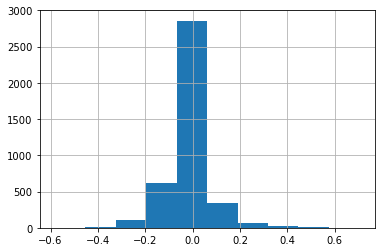

In [25]:
(merged.probability_x - merged.probability_y).hist()

# Qui script dove faccio import dei file di Adri

### Paris only hardneg not containing regions of interaction, from adri files

In [34]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')
            print(df.shape[0])

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [35]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
paris_exp = all_interactions[all_interactions.experiment.isin(paris_experiments)].reset_index(drop = True)

In [36]:
list_of_files_to_load = [
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_lowRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503872_HEK293_mRNA.bed', 
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_highRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__HEK293T.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503873_Mouse_brain_mRNA.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_AMT.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__mES.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_Amoto.bed',
]
list_of_names = ['paris' for i in range(len(list_of_files_to_load))]

In [37]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions'
original_data_path = os.path.join(check_data_path, 'original_data', 'check_predictions')
embedding_dir = os.path.join(check_data_path, 'embeddings')

emb = pd.read_csv(os.path.join(original_data_path, 'embeddings.filtered.bed'), sep = '\t', names = ['transcript','start','end','emb_name'])


n_samples_for_each_file = 10_000_000

df = read_and_concatenate_bed_files_paris(original_data_path, list_of_files_to_load, list_of_names, n_samples_for_each_file)
assert df[df.id_pair.duplicated()].shape[0] == 0

7209
6761
9103
7177
7874
435
21867
362


In [38]:
df_coord = df.id_pair.str.extractall('(.*)\+(.*)\+(.*)\+(.*)\+(.*)\+(.*)')
df_coord = df_coord.reset_index(drop = True).rename({
        0:'emb_name1',
        1:'emb_name2',
        2:'x1',
        3:'x2',
        4:'y1',
        5:'y2',
        },axis = 1)

df['emb_1'] = df_coord['emb_name1']
df['emb_2'] = df_coord['emb_name2']


df_coord['x1'] = df_coord['x1'].astype(int)
df_coord['x2'] = df_coord['x2'].astype(int)
df_coord['y1'] = df_coord['y1'].astype(int)
df_coord['y2'] = df_coord['y2'].astype(int)


df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name1', right_on = 'emb_name')
df_coord['start_window_x'] = df_coord['x1'] + df_coord['start']
df_coord['end_window_x'] = df_coord['x2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript1', 'start':'start_emb1', 'end': 'end_emb1'}, axis = 1)
df_coord = df_coord.drop(['x1', 'x2', 'emb_name'], axis = 1)




df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name2', right_on = 'emb_name')
df_coord['start_window_y'] = df_coord['y1'] + df_coord['start']
df_coord['end_window_y'] = df_coord['y2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript2', 'start':'start_emb2', 'end': 'end_emb2'}, axis = 1)
df_coord = df_coord.drop(['y1', 'y2', 'emb_name'], axis = 1)

df = pd.concat([df, df_coord], axis = 1)

assert (df.emb_1 == df.emb_name1).all()
assert (df.emb_2 == df.emb_name2).all()

df = df.drop(['emb_1', 'emb_2'], axis = 1)

In [42]:
set_pos = set(df.transcript1 + '_' + df.transcript2)

set_pos_paris = set(paris_exp.tr1 + '_' + paris_exp.tr2)

In [52]:
found = set_pos.intersection(set_pos_paris)
not_found = set_pos_paris - found

In [53]:
#I will loose these
len(not_found.intersection(set(paris_exp.tr2 + '_' + paris_exp.tr1)))

2384

In [57]:
#I will keep these
len(found)

14929

In [61]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [58]:
#I keep the ones with the same order
df = df[(df.transcript1 + '_' + df.transcript2).isin(found)]

In [62]:
diz = {}
for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = paris_exp[(paris_exp['tr1'] == tr1)&(paris_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/44309 [00:00<?, ?it/s]

In [63]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')

In [104]:
final_hn = pd.concat([df, distances], axis = 1)
subset = final_hn[(final_hn.distance_x>0) & (final_hn.distance_y>0)]

In [105]:
subset

,embedding1name,embedding2name,start_window1,end_window1,start_window2,end_window2,id_pair,emb_name1,emb_name2,transcript1,...,end_emb1,start_window_x,end_window_x,transcript2,start_emb2,end_emb2,start_window_y,end_window_y,distance_x,distance_y
3099,ENST00000396987_1,ENST00000275034_60,2200,2700,3334,3834,ENST00000396987_1+ENST00000275034_60+2200+2700...,ENST00000396987_1,ENST00000275034_60,ENST00000396987,...,5970,2200,2700,ENST00000275034,5900,11870,9234,9734,59,112
3575,ENST00000618457_1,ENST00000394329_8,5312,5812,2266,2766,ENST00000618457_1+ENST00000394329_8+5312+5812+...,ENST00000618457_1,ENST00000394329_8,ENST00000618457,...,5970,5312,5812,ENST00000394329,700,6670,2966,3466,1729,7767
3638,ENST00000633556_1,ENST00000262189_54,4657,5157,1236,1736,ENST00000633556_1+ENST00000262189_54+4657+5157...,ENST00000633556_1,ENST00000262189_54,ENST00000633556,...,5970,4657,5157,ENST00000262189,5300,11270,6536,7036,2264,4928
3646,ENST00000637265_35,ENST00000319080_1,2453,2953,693,1193,ENST00000637265_35+ENST00000319080_1+2453+2953...,ENST00000637265_35,ENST00000319080_1,ENST00000637265,...,9370,5853,6353,ENST00000319080,0,5970,693,1193,1463,1697
3731,ENST00000255305_1,ENST00000215832_51,1225,1725,2916,3416,ENST00000255305_1+ENST00000215832_51+1225+1725...,ENST00000255305_1,ENST00000215832_51,ENST00000255305,...,5970,1225,1725,ENST00000215832,5000,10970,7916,8416,1806,1902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35188,ENSMUST00000115104_24,ENSMUST00000114812_8,4501,5001,5410,5910,ENSMUST00000115104_24+ENSMUST00000114812_8+450...,ENSMUST00000115104_24,ENSMUST00000114812_8,ENSMUST00000115104,...,8270,6801,7301,ENSMUST00000114812,700,6670,6110,6610,7743,2164
49445,ENSMUST00000081619_19,ENSMUST00000040025_63,1615,2115,431,931,ENSMUST00000081619_19+ENSMUST00000040025_63+16...,ENSMUST00000081619_19,ENSMUST00000040025_63,ENSMUST00000081619,...,7770,3415,3915,ENSMUST00000040025,6200,12132,6631,7131,1228,4799
50960,ENSMUST00000075164_33,ENSMUST00000128570_8,3370,3870,3177,3677,ENSMUST00000075164_33+ENSMUST00000128570_8+337...,ENSMUST00000075164_33,ENSMUST00000128570_8,ENSMUST00000075164,...,9115,6570,7070,ENSMUST00000128570,700,6670,3877,4377,1807,48
51017,ENSMUST00000115104_105,ENSMUST00000072607_3,5421,5921,3381,3881,ENSMUST00000115104_105+ENSMUST00000072607_3+54...,ENSMUST00000115104_105,ENSMUST00000072607_3,ENSMUST00000115104,...,16370,15821,16321,ENSMUST00000072607,200,6170,3581,4081,4233,905


In [106]:
pred = pd.read_csv(os.path.join(check_data_path, 'predictions.csv'))

In [107]:
subset['id_sample'] = 'paris+' + subset.id_pair

/tmp/ipykernel_473531/2791520523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['id_sample'] = 'paris+' + subset.id_pair


In [110]:
paris_exp['w'] = paris_exp.x2 - paris_exp.x1
paris_exp['h'] = paris_exp.y2 - paris_exp.y1
hq = paris_exp[(paris_exp.w > 20) & (paris_exp.h > 20)]
subset = subset[(subset.transcript1 + '_' + subset.transcript2).isin(set(hq.tr1 + '_' + hq.tr2))]
subset = pred.merge(subset, on = 'id_sample')
(subset.probability<0.5).sum()/subset.shape[0]

0.6666666666666666

In [112]:
subset.shape[0]

42

In [95]:
row = subset.iloc[1]
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000618457', 'ENST00000394329', 0, 5970, 1729, 700, 6670, 7767)

In [96]:
all_interactions = paris_exp[(paris_exp['tr1'] == row.transcript1)&(paris_exp['tr2'] == row.transcript2)]

In [97]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
103443,ENST00000618457,7699,7718,ENST00000394329,14437,14456,interaction15212_PARIS1__Hela_lowRNase,1,RISE0256751,hs_PARIS1__Hela_lowRNase


In [102]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [103]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
ricseq_exp = all_interactions[all_interactions.experiment.isin(ricseq_experiments)].reset_index(drop = True)

In [180]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions/original_data/'
emb = pd.read_csv(os.path.join(check_data_path, 'check_predictions', 'embeddings.filtered.bed'), sep = '\t', names = ['transcript','start','end','emb_name'])
assert (emb.emb_name.str.extractall('(.*)_(.*)').reset_index(drop = True)[0] == emb.transcript).all()
df = pd.read_csv(os.path.join(check_data_path, 'giorgio.ricseq.txt'), sep = '\t').reset_index(drop = True)

In [181]:
df_coord = df.id_pair.str.extractall('(.*)\+(.*)\+(.*)\+(.*)\+(.*)\+(.*)')

df_coord = df_coord.reset_index(drop = True).rename({
        0:'emb_name1',
        1:'emb_name2',
        2:'x1',
        3:'x2',
        4:'y1',
        5:'y2',
        },axis = 1)

df['emb_1'] = df_coord['emb_name1']
df['emb_2'] = df_coord['emb_name2']

df_coord['x1'] = df_coord['x1'].astype(int)
df_coord['x2'] = df_coord['x2'].astype(int)
df_coord['y1'] = df_coord['y1'].astype(int)
df_coord['y2'] = df_coord['y2'].astype(int)


df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name1', right_on = 'emb_name')
df_coord['start_window_x'] = df_coord['x1'] + df_coord['start']
df_coord['end_window_x'] = df_coord['x2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript1', 'start':'start_emb1', 'end': 'end_emb1'}, axis = 1)
df_coord = df_coord.drop(['x1', 'x2', 'emb_name'], axis = 1)




df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name2', right_on = 'emb_name')
df_coord['start_window_y'] = df_coord['y1'] + df_coord['start']
df_coord['end_window_y'] = df_coord['y2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript2', 'start':'start_emb2', 'end': 'end_emb2'}, axis = 1)
df_coord = df_coord.drop(['y1', 'y2', 'emb_name'], axis = 1)

In [182]:
df = pd.concat([df, df_coord], axis = 1)

assert (df.emb_1 == df.emb_name1).all()
assert (df.emb_2 == df.emb_name2).all()

df = df.drop(['emb_1', 'emb_2'], axis = 1)

In [185]:
df.category.value_counts()

smartneg               384509
easyneg_singlepatch     80109
hardneg_singlepatch     18686
positive                 9409
hardneg                  9343
easyneg                   189
Name: category, dtype: int64

In [186]:
df[df.category.isin(['hardneg_singlepatch', 'hardneg'])]

,Unnamed: 0,id_pair,name_analysis,probability,name,score_1,score_2,true_value,binary_true_value,macro_group,...,transcript1,start_emb1,end_emb1,start_window_x,end_window_x,transcript2,start_emb2,end_emb2,start_window_y,end_window_y
9409,9409,ENST00000001146_1+ENST00000389286_24+2678+3178...,hardneg_easy,0.395211,interaction58_RIC-seq__HeLa_merge.InterGene.arms,2,2,negative,0,hardneg,...,ENST00000001146,0,4732,2678,3178,ENST00000389286,2300,8270,4417,4917
9410,9410,ENST00000003912_1+ENST00000276204_7+3463+3963+...,hardneg_easy,0.279407,interaction78_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3463,3963,ENST00000276204,600,6570,2478,2978
9411,9411,ENST00000003912_1+ENST00000260270_1+3498+3998+...,hardneg_easy,0.294737,interaction75_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3498,3998,ENST00000260270,0,3144,1152,1652
9412,9412,ENST00000003912_1+ENST00000354212_1+3565+4065+...,hardneg_easy,0.328119,interaction76_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3565,4065,ENST00000354212,0,5970,3450,3950
9413,9413,ENST00000005260_1+ENST00000399070_1+2395+2895+...,hardneg_easy,0.370093,interaction83_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000005260,0,3645,2395,2895,ENST00000399070,0,5124,2917,3417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,37433,ENST00000626826_304+ENST00000369604_1+1320+182...,hardneg_hard,0.262093,interaction128512_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,30300,36270,31620,32120,ENST00000369604,0,3657,1853,2353
37434,37434,ENST00000626826_1136+ENST00000257868_1+4357+48...,hardneg_hard,0.466847,interaction128486_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,113500,119470,117857,118357,ENST00000257868,0,5970,116,616
37435,37435,ENST00000626826_1990+ENST00000566029_5+5182+56...,hardneg_hard,0.661785,interaction128461_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,198900,204870,204082,204582,ENST00000566029,400,6370,473,973
37436,37436,ENST00000626826_1359+ENST00000376954_1+4274+47...,hardneg_hard,0.377358,interaction128490_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,135800,141770,140074,140574,ENST00000376954,0,5970,2697,3197


In [330]:
hn = df[df.category.isin(['hardneg_singlepatch', 'hardneg'])] #df[df.category.isin(['hardneg_singlepatch', 'hardneg', 'positive'])]
set_pos = set(hn.transcript1 + '_' + hn.transcript2)

set_pos_ricseq = set(ricseq_exp.tr1 + '_' + ricseq_exp.tr2)

In [214]:
len(set_pos)

9021

In [215]:
len(set_pos_ricseq)

116280

In [216]:
len(set_pos.intersection(set_pos_ricseq))

9021

In [217]:
to_drop = set_pos - set_pos.intersection(set_pos_ricseq)
print(len(to_drop))

0


In [228]:
diz = {}
for idx, row in tqdm(hn.iterrows(), total = hn.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = ricseq_exp[(ricseq_exp['tr1'] == tr1)&(ricseq_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/28029 [00:00<?, ?it/s]

In [229]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')

In [331]:
final_hn = pd.concat([hn, distances], axis = 1)

In [333]:
subset = final_hn[(final_hn.distance_x>0) & (final_hn.distance_y>0)]
subset = subset[subset.score_1 > 1]

In [334]:
vc = (subset.probability<0.5).value_counts()
tnr = (vc.loc[True])/ subset.shape[0]
print(tnr)

0.6190476190476191


In [335]:
row = subset.iloc[1]

In [307]:
all_interactions = ricseq_exp[(ricseq_exp['tr1'] == row.transcript1)&(ricseq_exp['tr2'] == row.transcript2)]

In [308]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
41857,ENST00000272793,7153,7223,ENST00000366630,6325,6351,interaction42000_RIC-seq__HeLa_merge.InterGene...,2,"ST-E00205:676:HTJL3CCXY:4:2206:23673:39897,ST-...",hs_RIC-seq__HeLa_merge.InterGene.arms


In [309]:
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000272793', 'ENST00000366630', 0, 5970, 1183, 0, 5970, 355)

In [310]:
subset_adri = df.loc[(df["classify_emb"].str.count("__positive")==0)&(df["category"].isin(['hardneg_singlepatch', 'hardneg']))]
subset_adri = subset_adri.merge(final_hn[['id_pair', 'distance_x', 'distance_y']], on = 'id_pair')

In [311]:
wrong_adri = subset_adri[(subset_adri.distance_x == 0) & (subset_adri.distance_y == 0)]
row = wrong_adri.iloc[0]

In [312]:
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000011898', 'ENST00000313578', 0, 4322, 0, 0, 1835, 0)

In [313]:
all_interactions = ricseq_exp[(ricseq_exp['tr1'] == row.transcript1)&(ricseq_exp['tr2'] == row.transcript2)]

In [314]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
49969,ENST00000011898,2592,2678,ENST00000313578,1255,1317,interaction50148_RIC-seq__HeLa_merge.InterGene...,1,ST-E00205:676:HTJL3CCXY:4:2213:7557:28716,hs_RIC-seq__HeLa_merge.InterGene.arms


In [15]:
subset = df.loc[(df["classify_emb"].str.count("__positive")==0)&(df["category"]=="hardneg")]
vc = (subset.probability<0.5).value_counts()
tnr = (vc.loc[True])/ subset.shape[0]
print(tnr)

0.7129859387923904


In [5]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions50'
original_data_path = os.path.join(check_data_path, 'original_data')
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [6]:
# Function to parse the content
def parse_fa_content(content):
    entries = content.strip().split('>')
    data = []
    for entry in entries:
        if entry:
            lines = entry.split('\n')
            id_query = lines[0]
            cdna = ''.join(lines[1:])
            data.append([id_query, cdna])
    return pd.DataFrame(data, columns=['id_query', 'cdna'])


with open(os.path.join(original_data_path, 'embeddings.filtered.fa'), 'r') as file:
    file_content = file.read()

# Parse the content and create the DataFrame
df_query = parse_fa_content(file_content)

In [7]:
# devo droppare tutti quelli che non iniziano per ens
df_query['ens_gene'] = df_query['id_query'].str.startswith('ENS')
df_query = df_query[df_query.ens_gene].reset_index(drop = True)
df_query = df_query.drop('ens_gene', axis = 1)

In [6]:
#droppo quelli che gia ci sono
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [8]:
df_query.shape[0]

53979

In [9]:
df_query.to_csv(os.path.join(check_data_path, f'embedding_query.csv'), index = False)

In [68]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 6.94
estimated # days: 0.29
estimated terabytes (pessimistic): 0.3
estimated terabytes (realistic): 0.2


In [15]:
df_query['len_cdna'] = df_query.apply(lambda x: len(x.cdna), axis = 1)

<AxesSubplot:>

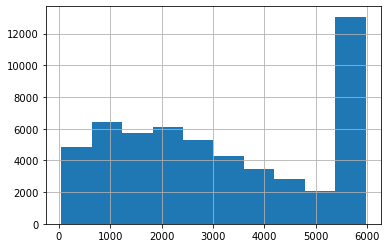

In [16]:
df_query['len_cdna'].hist()

In [17]:
df_query['len_cdna'].max()

5970

### prendo un subset di Paris

In [24]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = list_of_names[_]
        df['id_pair'] = df['id_pair'] + '+' + df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [25]:
list_of_files_to_load = [
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_lowRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503872_HEK293_mRNA.bed', 
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_highRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__HEK293T.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503873_Mouse_brain_mRNA.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_AMT.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__mES.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_Amoto.bed',
    
    'Giorgio.NegativeBySwap.mm_PARIS1__mES.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__Hela_highRNase.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS2__GSM4503872_HEK293_mRNA.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS2__HEK293_AMT.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__Hela_lowRNase.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__HEK293T.embedding.bed',
]
list_of_names = ['paris' for i in range(len(list_of_files_to_load))]

In [32]:
n_samples_for_each_file = 1_000_000

df = read_and_concatenate_bed_files_paris(original_data_path, list_of_files_to_load, list_of_names, n_samples_for_each_file)

assert df[df.id_pair.duplicated()].shape[0] == 0

In [33]:
(3.5 * df.shape[0]) / 400_000

16.6742275

In [34]:
df.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

### prendo un subset di Ricseq

In [30]:
def read_and_concatenate_bed_files(directory, list_of_files_to_load, list_of_names):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        file_path = os.path.join(directory, filename)
        # Read the .bed file into a dataframe
        df = pd.read_csv(file_path, sep='\t')

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = list_of_names[_]
        df['id_pair'] = df['id_pair'] + '+' + df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df


list_of_files_to_load = os.listdir(original_data_path) # Questo è per tutti i dati
list_of_files_to_load = ['Giorgio.positivi_e_hardneg.no_train_eval.RIC-seq__HeLa_merge.InterGene.arms.bed', 'Giorgio.NegativeBySwap.hs_RIC-seq__HeLa_merge.InterGene.arms.embedding.bed']
list_of_names=['ricseq_pos_hn', 'ricseq_swap_neg']

df = read_and_concatenate_bed_files(original_data_path, list_of_files_to_load, list_of_names)

assert df[df.id_pair.duplicated()].shape[0] == 0

In [36]:
df.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

In [32]:
# n_samples = 500_000

# pos_hn = df[df.id_pair.str.startswith('ricseq_pos_hn')]

# swap_neg = df[df.id_pair.str.startswith('ricseq_swap_neg')].sample(n_samples//2)

# subset = pd.concat([
#     pos_hn.sample(min(pos_hn.shape[0], n_samples//2)), 
#     swap_neg.sample(min(swap_neg.shape[0], n_samples//2)), 
# ], axis = 0)

# subset.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

# subset.shape[0], pos_hn.shape[0], swap_neg.shape[0]

# subset.id_pair.iloc[0]

In [38]:
df.id_pair.iloc[0]

'ricseq_pos_hn+ENST00000000233_1+ENST00000262960_1+28+78+2188+2238'